# Music Artist Collaboration Driven Recommendation 

## Connecting to the database and importing project code

In [19]:
from sqlalchemy import create_engine
from project_code import MusicBrainzDatabase, CollaborationNetworkGraph, CollaborationNetworkPlot, RecommendationEngine
import config

## MusicBrainzDatabase

A class made to interace with the MusicBrainz Database. Most methods are for querying the database and returning dataframe objects or other query information. It also includes a helper method for turning a dataframe object into an artist object used in other classes.

In [20]:
# Setup database connection
host = config.DB_HOST
user = config.DB_USER
database = config.DB_NAME
password = config.DB_PASSWORD

# Initialize database connection
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:5432/{database}")
db = MusicBrainzDatabase(engine)

# Test IDs for db example usage (Nico Segal & Vic Mensa)
artist_id1 = 888799
artist_id2 = 873735

### Test Queries

#### Direct Collaborators

Artists that share a recording with the main artist

In [21]:
db.get_direct_collaborators(artist_id1).head()

,artist_id,artist_name,appearance_count
0,1098704,The Social Experiment,17
1,873735,Vic Mensa,8
2,1244337,Jamila Woods,5
3,905024,Chance the Rapper,4
4,1539936,The O’My’s,3


#### Credit Collaborators

Credited artists found in the main artist's recordings (e.g. producer, vocalist)

In [22]:
db.get_credit_collaborators(artist_id1).head()

,artist_id,artist_name,credit_type,appearance_count
0,1007633,Sean Oakley,mix,16
1,1002478,Nate Fox,producer,14
2,905024,Chance the Rapper,vocal,9
3,2545600,Michael Kolar,mix,7
4,155298,J Dilla,producer,3


#### Featured-in Collaborators

Artists where the main artists was credited in their recordings

In [23]:
db.get_featured_in_collaborations(artist_id1).head()

,artist_id,artist_name,appearance_count
0,1107424,Bleachers,3
1,629203,Andrew Wyatt,2
2,112605,Mark Ronson,2
3,127482,Ye,1
4,587302,Francis and the Lights,1


#### Shared recordings

Recordings shared between two artists

In [24]:
db.get_shared_recordings(artist_id1, artist_id2).head()

,id,recording_name
0,17473799,Callie
1,35124882,Clear Eyes
2,35124879,Come Closer
3,17473800,Don't Leave
4,40452291,Hey Jane


## Getting Artist IDs to Seed The Graph

### Use Search Query to Find Artist IDs

In [25]:
# Search for an artist
search_name = "BADBADNOTGOOD"
db.find_artist_by_name(search_name)

,artist_id,artist_name,comment
0,835782,BADBADNOTGOOD,Canadian instrumental band


### Save IDs as Seeds to Build the Collaboration Network

In [26]:
seed_artist_ids = [
    1291263,    # Smino
    1002481,    # Saba
    888799,     # Nico Segal
    1124552,    # Raury
    835782,     # BADBADNOTGOOD
]

# Create Artist objects from IDs
seed_artists = [db.find_artist_by_id(artist_id) for artist_id in seed_artist_ids]

#### Optionally Add Additional Seeds From Direct Artist Relationship (e.g. Band members)

Not recommended if inputting lots of seed artists. 

In [27]:
def seed_connected_artists(db, seed_artists):
    new_seed_artists = []
    for artist in seed_artists:
        connected_artists = db.get_direct_artist_connections(artist.id).values.tolist()
        if connected_artists:
            print(f"Connected Artists to {artist.name}:")
            for artist_id, _ in connected_artists:
                new_artist = db.find_artist_by_id(artist_id)
                print(f"  - {new_artist.name} (ID: {new_artist.id})")
                
                # Skip if already found
                if artist_id in seed_artist_ids: continue
                if artist_id in [a.id for a in new_seed_artists]: continue
                new_seed_artists.append(new_artist)

    seed_artists.extend(new_seed_artists)
    print(f"\nTotal seed artists: {len(seed_artists)}")
    print(f"Seed Artists: {[artist.name for artist in seed_artists]}")

    return seed_artists

# seed_artists = seed_connected_artists(db, seed_artists)

## CollaborationNetworkGraph/Plot

These are used to create the network of artists and then visualize them. Building the graph is done in 3 phases. First, primary connections are found, then they're filtered to only the highest weighted connections, then connections are found between the rest of the nodes left in the graph.


Finding artist connections from 5 seed artists...
Filtered to 48 nodes, keeping top 10 connections per seed artist

Finding interconnections among 43 collaborators...
Added 47 interconnections between collaborators

Visualization graph: 48 nodes, 96 edges

Edge type breakdown:
  credit: 14
  direct: 35
  interconnection: 47


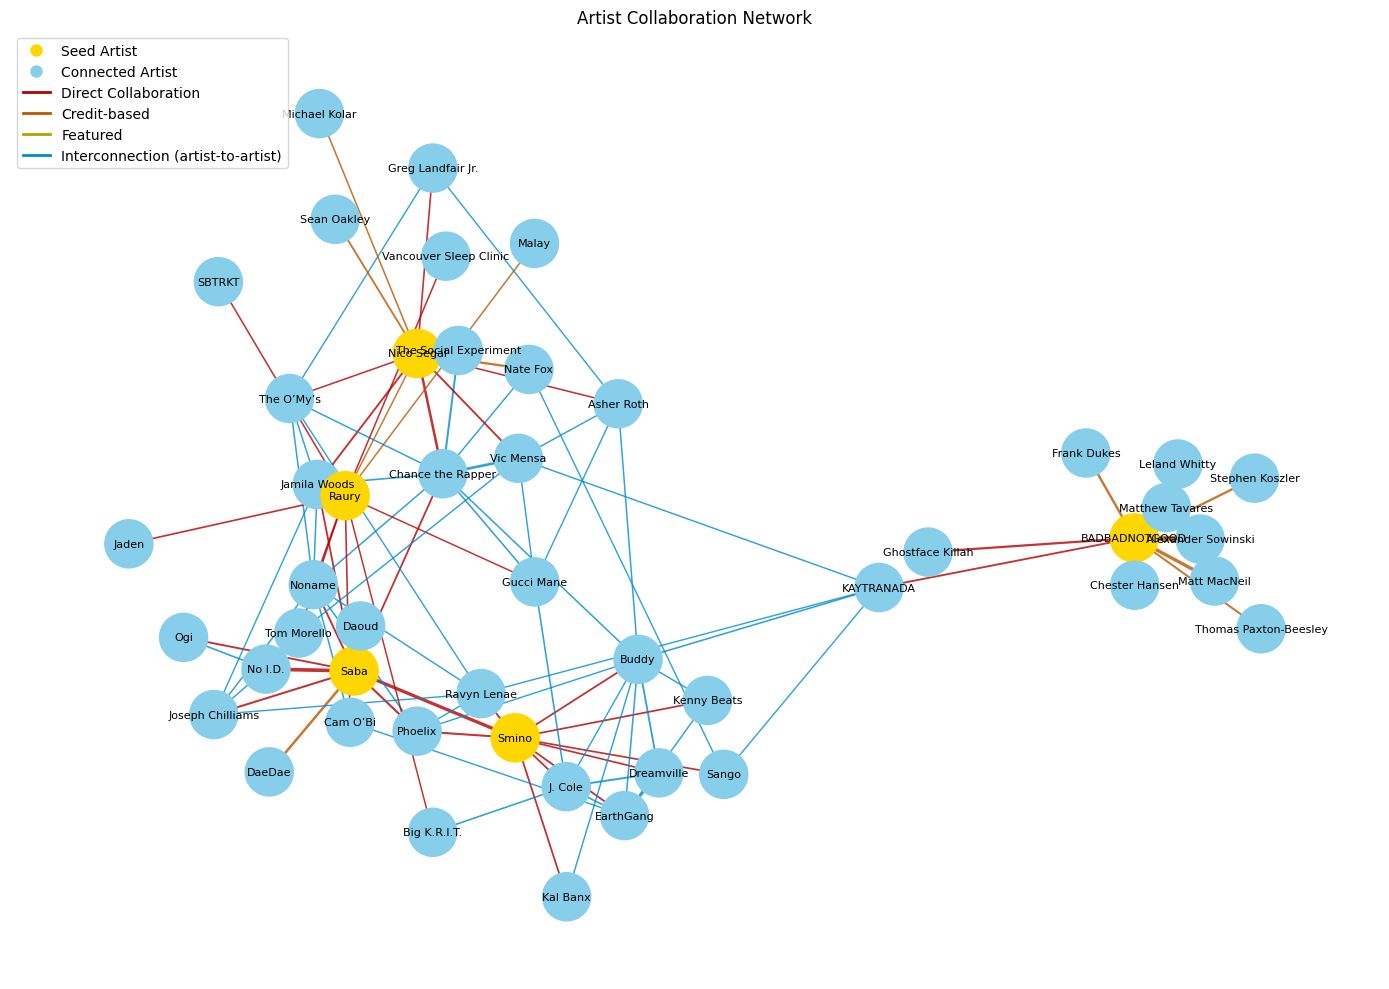

In [28]:
# Adjust inversely to the number of seed artists to limit complexity
# Recommend 10 for 5 artists
connections_per_seed = 10

graph = CollaborationNetworkGraph(db)
graph.build(seed_artists, top_k_per_seed=connections_per_seed)

plot = CollaborationNetworkPlot(graph.graph)
plot.build()

## RecommendationEngine

This class is used to handle the recommendations. It has four main functions for getting the main artist and song recommendations, as well as discovery recommendations.

In [29]:
# Initialize the RecommendationEngine
recommendations = RecommendationEngine(graph, db, seed_artists)

### Artist Recommendations (PageRank)

In [30]:
recommendations.get_artists()

,name,score
0,Chance the Rapper,0.0506
1,Matthew Tavares,0.0297
2,Vic Mensa,0.0264
3,Noname,0.0253
4,J. Cole,0.0252
5,Dreamville,0.0250
6,No I.D.,0.0249
7,Buddy,0.0234
8,EarthGang,0.0219
9,The Social Experiment,0.0207


#### Discovery Picks (Mixed)

Score - product of the closeness centrality and betweenness centrality scores

In [31]:
recommendations.get_discovery_artists()

,name,score
0,KAYTRANADA,0.0179
1,Ravyn Lenae,0.0163
2,The O’My’s,0.0071
3,Gucci Mane,0.0066
4,Joseph Chilliams,0.0059
5,Phoelix,0.0050
6,Asher Roth,0.0040
7,Sango,0.0037
8,Jamila Woods,0.0031
9,Greg Landfair Jr.,0.0026


### Song Recommendations (Common Neighbor)

Common Neighbor artists' songs with seed artist

In [32]:
recommendations.get_songs()

,song,seed_artists,recommended_artist,shared_with
0,Kompany,Smino,Phoelix,2
1,Modennaminute,Smino,Phoelix,2
2,BET Uncut,Smino,Chance the Rapper,2
3,Eternal,Smino,Chance the Rapper,2
4,Ace,"Smino, Saba",Noname,2
5,Amphetamine,Smino,Noname,2
6,BASQUIAT,Saba,Jamila Woods,2
7,Butter,Saba,Jamila Woods,2
8,3D,Smino,Ravyn Lenae,1
9,Glass Flows,Smino,Ravyn Lenae,1


#### Discovery Picks (Mixed)

Songs with the seed artist and a recommended artist from the discovery picked artists

In [33]:
recommendations.get_discovery_songs()

,song,seed_artists,recommended_artist,score
0,Blue,BADBADNOTGOOD,KAYTRANADA,0.0179
1,Lavender,BADBADNOTGOOD,KAYTRANADA,0.0179
2,Puddles,Saba,The O’My’s,0.0071
3,Honey Dip,Nico Segal,The O’My’s,0.0071
4,Dead People,Raury,Gucci Mane,0.0066
5,Bastard / Lemonade,BADBADNOTGOOD,Gucci Mane,0.0066
6,30secchop,Saba,Joseph Chilliams,0.0059
7,Matilda,Saba,Joseph Chilliams,0.0059
8,Callie,Nico Segal,Vic Mensa,0.0049
9,Clear Eyes,Nico Segal,Vic Mensa,0.0049
